# Masking / clipping raster

One common task in raster processing is to clip raster files based on a Polygon. The following example shows how to clip a large raster based on a bounding box around Helsinki Region.


- Import modules and specify the input and output filepaths

In [4]:
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg

# import pycrs
import os

%matplotlib inline

# Data dir
data_dir = "data"

# Input raster
fp = os.path.join(data_dir, "kilimanjaro.tif")

# Output raster
out_tif = os.path.join(data_dir, "kilimanjaro_masked.tif")

- Let's start by opening the raster in read mode and visualizing it (using specific colormap called `terrain`):

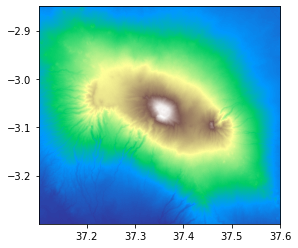

<AxesSubplot:>

In [6]:
# Read the data
data = rasterio.open(fp)

# Visualize the NIR band
show(data, cmap="terrain")

In [7]:
data.shape

(1620, 1800)

Okey, as you can see, we have a huge raster file where we can see the coastlines of Finland and Estonia. What we want to do next is to create a bounding box around Helsinki region and clip the raster based on that.

- Next, we need to create a bounding box for our area of interest with Shapely.

In [8]:
# WGS84 coordinates
minx, miny = 24.60, 60.00
maxx, maxy = 25.22, 60.35
bbox = box(minx, miny, maxx, maxy)

- Create a GeoDataFrame from the bounding box

In [9]:
geo = gpd.GeoDataFrame({"geometry": bbox}, index=[0], crs=from_epsg(4326))
print(geo)

                                            geometry
0  POLYGON ((25.22 60, 25.22 60.35, 24.6 60.35, 2...


As we can see now we have a GeoDataFrame with Polygon inside. To be able to clip the raster with this Polygon, it is required that the data has identical coordinate reference system.

-  Re-project into the same coordinate system as the raster data. We can access the crs of the raster using attribute `.crs.data`:

In [11]:
# Project the Polygon into same CRS as the grid
geo = geo.to_crs(crs=data.crs.data)

# Print crs
geo.crs

{'init': 'epsg:32634'}

- Next we need to get the coordinates of the geometry in such a format that rasterio wants them. This can be conducted easily with following function:

In [12]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json

    return [json.loads(gdf.to_json())["features"][0]["geometry"]]

- Get the geometry coordinates by using the function.

In [13]:
coords = getFeatures(geo)
print(coords)

[{'type': 'Polygon', 'coordinates': [[[735275.3533476053, 6658919.843253607], [732783.55612074, 6697846.086795722], [698608.1329965619, 6695816.080575278], [700733.5832412266, 6656875.248540204], [735275.3533476053, 6658919.843253607]]]}]


Okay, as we can see rasterio wants to have the coordinates of the Polygon in `GeoJSON` format.

- Now we are ready to clip the raster with the polygon using the `coords` variable that we just created. Clipping the raster can be done easily with the `mask` function that we imported in the beginning from `rasterio`, and specifying ``clip=True``.


In [16]:
# Clip the raster with Polygon
out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)

- Next, we need to modify the metadata. Let's start by copying the metadata from the original data file.

In [17]:
# Copy the metadata
out_meta = data.meta.copy()
print(out_meta)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 8877, 'height': 8106, 'count': 7, 'crs': CRS({'init': 'epsg:32634'}), 'transform': Affine(28.5, 0.0, 600466.5,
       0.0, -28.5, 6784966.5)}


- Next we need to parse the EPSG value from the CRS so that we can create a `Proj4` -string using `PyCRS` library (to ensure that the projection information is saved correctly).

In [18]:
# Parse EPSG code
epsg_code = int(data.crs.data["init"][5:])
print(epsg_code)

32634


- Now we need to update the metadata with new dimensions, transform (affine) and CRS (as Proj4 text):

In [19]:
out_meta.update(
    {
        "driver": "GTiff",
        "height": out_img.shape[1],
        "width": out_img.shape[2],
        "transform": out_transform,
        "crs": pycrs.parser.from_epsg_code(epsg_code).to_proj4(),
    }
)

- Finally, we can save the clipped raster to disk with following command:

In [22]:
with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(out_img)

- Let's still check that the result is correct by plotting our new clipped raster.

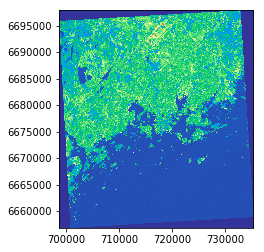

In [23]:
# Open the clipped raster file
clipped = rasterio.open(out_tif)

# Visualize
show((clipped, 5), cmap="terrain")

Great, it worked! This is how you can easily clip (*mask*) raster files with rasterio.